Frame enumuration and submission to Hyp3 with Tropo, Iono, SET corrections.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from s1_frame_enumerator import (get_s1_stack, 
                                 filter_s1_stack_by_geometric_coverage_per_pass, 
                                 get_global_s1_frames, 
                                 get_overlapping_s1_frames, 
                                 enumerate_dates, 
                                 frames2gdf, 
                                 enumerate_gunw_time_series)
from shapely.geometry import Point
import geopandas as gpd
from rasterio.crs import CRS
import matplotlib.pyplot as plt
import warnings
import json
import pandas as pd
import datetime

In [3]:
AOI_NAME = 'Los-Angeles-0' #'Los Angeles' # 'Hawaii'
WEATHER_MODEL = 'HRRR'

In [4]:
if WEATHER_MODEL == 'HRRR':
    assert AOI_NAME in ['Maine', 'Bellingham', 'Los-Angeles-0', 
                        'Los-Angeles-1', 'Norfolk', 'Wax-Lake', 'Anchorage',
                        'New-York']

In [5]:
GEO_DICT = {'Los-Angeles-0':  Point(-118, 34).buffer(1),
            'Los-Angeles-1':  Point(-118, 34).buffer(1),
            'Hawaii-0': Point(-155.5, 19.5).buffer(1),
            'Hawaii-1': Point(-155.5, 19.5).buffer(1),
            'Norfolk': Point(-76.5, 36.4).buffer(1),
            'Somalia': Point(41, 1.5).buffer(1),
            'Tibet': Point(92, 41.5).buffer(1),
            'Norway': Point(13, 65).buffer(1),
            'Aleutian': Point(-177, 52).buffer(.25),
            'Wax-Lake': Point(-91.5, 30).buffer(1),
            'Bellingham': Point(-122.5, 48.5).buffer(1),
            'Maine': Point(-69, 47).buffer(1),
            'Anchorage': Point(-150, 61).buffer(1),
            'Chile': Point(-69.0355, -19.449).buffer(2.5),
            'Saudi-Arabia': Point(47.5, 24).buffer(2.5),
            'New-York': Point(-74, 42).buffer(2)
            }

TRACK_DICT = {'Los-Angeles-0': [64],
              'Los-Angeles-1': [71],
              'Hawaii-0': [124],
              'Hawaii-1': [87],
              'Norfolk': [4],
              'Somalia': [87],
              'Tibet': [48],
              'Norway': [37],
              'Aleutian': [59],
              'Wax-Lake': [63],
              'Bellingham': [137],
              'Maine': [164],
              'Anchorage': [131],
              'Chile': [54],
              'Saudi-Arabia': [72],
              'New-York': [33]
              }

In [6]:
aoi_geo = GEO_DICT[AOI_NAME]
track_numbers = TRACK_DICT[AOI_NAME]

df_aoi = gpd.GeoDataFrame(geometry=[aoi_geo], crs=CRS.from_epsg(4326))

In [7]:
frames = get_overlapping_s1_frames(aoi_geo, track_numbers=track_numbers)

In [8]:
# There will be lots of ways to do this more efficiently i.e. only include frames with overlap of a land mask
# Even to be more confident would likely want some percentage
# Currently, we just shrunk our AOI and excluded a frame
if AOI_NAME == 'Aleutian':
    frames = list(filter(lambda f: f.frame_id!= 9101, frames))

In [9]:
df_frames_all = frames2gdf(frames)
df_frames_all.head()

,frame_id,hemisphere,track_number_min,track_number_max,geometry
0,9847,west,64,64,"POLYGON Z ((-118.47827 32.36110 0.00000, -118...."
1,9848,west,64,64,"POLYGON Z ((-118.74228 33.52202 0.00000, -118...."
2,9849,west,64,64,"POLYGON Z ((-119.01018 34.68551 0.00000, -119...."


<Axes: >

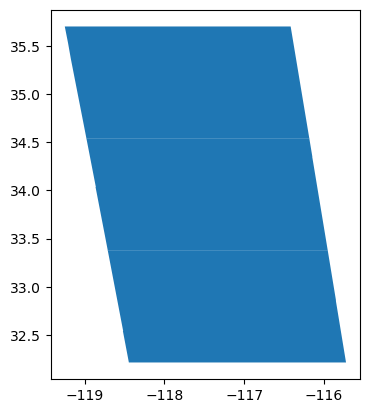

In [10]:
df_frames_all.plot()

(31.21359933194077, 36.70334208606267)

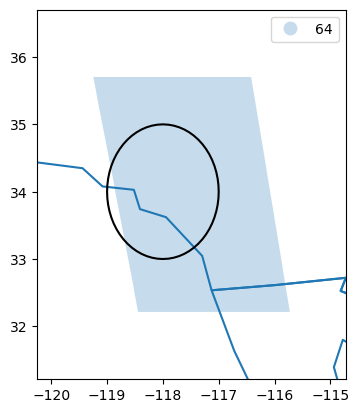

In [11]:
fig, ax = plt.subplots()
df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
df_world.boundary.plot(ax=ax)
df_frames_by_track = df_frames_all.dissolve(by='track_number_min').reset_index(drop=False)
df_frames_by_track.plot(ax=ax, 
                        column='track_number_min',
                        categorical=True,
                        alpha=.25, 
                        legend=True)
df_aoi.boundary.plot(ax=ax, edgecolor='black')
xmin, ymin, xmax, ymax = df_frames_by_track.total_bounds
ax.set_xlim(xmin - 1, xmax + 1)
ax.set_ylim(ymin - 1, ymax + 1)

(31.21359933194077, 36.70334208606267)

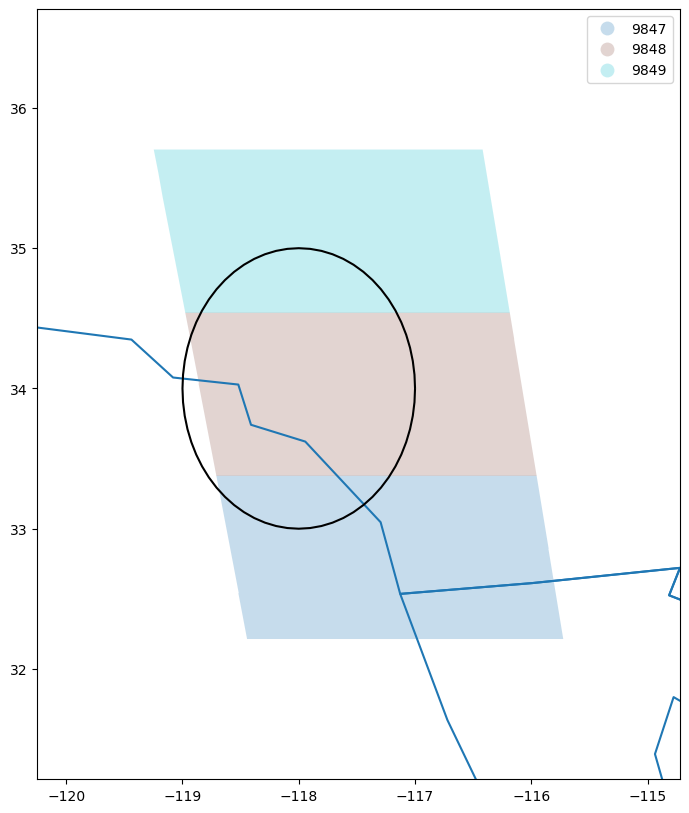

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
df_world.boundary.plot(ax=ax)
df_frames_all.plot(ax=ax, 
                   column='frame_id', 
                   alpha=.25,
                   categorical=True,
                   legend=True)
df_aoi.boundary.plot(ax=ax, edgecolor='black')

xmin, ymin, xmax, ymax = df_frames_by_track.total_bounds
ax.set_xlim(xmin - 1, xmax + 1)
ax.set_ylim(ymin - 1, ymax + 1)

# Get Stack from Frame

Here a stack is a list of images with metadata and extents. We note the stack here is not arbitrarily constructed and at some point might be nice to create a simple class to encapsulate it. However, here a stack is one that can be organized to do interferometry over the frames.

1. Per pass coverage $\geq 80$% as it pertains to the frame's coverage geometry
2. Contiguous coverage through frames (determined as Polygon object)

Requires:

1. Frames to be contiguous (otherwise 2. does not make sense)
2. Requires single track or two sequential tracks (we only check if the track numbers are sequential)

In [13]:
df_stack = get_s1_stack(frames)
df_stack.head()

,slc_id,start_time,stop_time,url,track_number,polarization,orbit,beam_mode,size_gb,stack_repeat_pass_id,repeat_pass_timestamp,geometry
0,S1A_IW_SLC__1SDV_20150327T014926_20150327T0149...,2015-03-27 01:49:26+00:00,2015-03-27 01:49:56+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,64,VV+VH,5211,IW,4.974678,5,2015-03-27 00:00:00+00:00,"POLYGON ((-118.84671 33.97964, -118.43211 32.1..."
1,S1A_IW_SLC__1SDV_20150327T014954_20150327T0150...,2015-03-27 01:49:54+00:00,2015-03-27 01:50:21+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,64,VV+VH,5211,IW,4.691330,5,2015-03-27 00:00:00+00:00,"POLYGON ((-119.19286 35.52634, -118.79826 33.8..."
2,S1A_IW_SLC__1SDV_20150327T015019_20150327T0150...,2015-03-27 01:50:19+00:00,2015-03-27 01:50:46+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,64,VV+VH,5211,IW,4.710532,5,2015-03-27 00:00:00+00:00,"POLYGON ((-119.54218 37.02169, -119.15354 35.3..."
3,S1A_IW_SLC__1SSV_20150502T014928_20150502T0149...,2015-05-02 01:49:28+00:00,2015-05-02 01:49:58+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,64,VV,5736,IW,2.731071,7,2015-05-02 00:00:00+00:00,"POLYGON ((-118.84749 33.98007, -118.43279 32.1..."
4,S1A_IW_SLC__1SSV_20150502T014955_20150502T0150...,2015-05-02 01:49:55+00:00,2015-05-02 01:50:23+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,64,VV,5736,IW,2.445739,7,2015-05-02 00:00:00+00:00,"POLYGON ((-119.18191 35.47755, -118.79901 33.8..."


# Select N Dates from stack

To make sure there is weather model availability, we are going to truncate the stack to dates on or before `2022-03-01`.

In [14]:
if AOI_NAME == 'Tibet':
    N = 5
else:
    N = 3

# Give ourselves 1 year buffer
MAX_DATE = pd.Timestamp('2022-03-01', tz='UTC')
df_stack_f = df_stack[df_stack.repeat_pass_timestamp <= MAX_DATE]

dates = sorted(df_stack_f.repeat_pass_timestamp.unique(), reverse=True)
df_stack_f = df_stack_f[df_stack_f.repeat_pass_timestamp >= dates[N]].reset_index(drop=True)
df_stack_f.head()

,slc_id,start_time,stop_time,url,track_number,polarization,orbit,beam_mode,size_gb,stack_repeat_pass_id,repeat_pass_timestamp,geometry
0,S1A_IW_SLC__1SDV_20220113T015007_20220113T0150...,2022-01-13 01:50:07+00:00,2022-01-13 01:50:37+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,64,VV+VH,41436,IW,4.510663,285,2022-01-13 00:00:00+00:00,"POLYGON ((-118.80016 33.81636, -118.38660 32.0..."
1,S1A_IW_SLC__1SDV_20220113T015034_20220113T0151...,2022-01-13 01:50:34+00:00,2022-01-13 01:51:02+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,64,VV+VH,41436,IW,4.377149,285,2022-01-13 00:00:00+00:00,"POLYGON ((-119.15805 35.36104, -118.76421 33.6..."
2,S1A_IW_SLC__1SDV_20220113T015100_20220113T0151...,2022-01-13 01:51:00+00:00,2022-01-13 01:51:27+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,64,VV+VH,41436,IW,4.385168,285,2022-01-13 00:00:00+00:00,"POLYGON ((-119.51548 36.85461, -119.12757 35.2..."
3,S1A_IW_SLC__1SDV_20220125T015006_20220125T0150...,2022-01-25 01:50:06+00:00,2022-01-25 01:50:36+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,64,VV+VH,41611,IW,4.577207,286,2022-01-25 00:00:00+00:00,"POLYGON ((-118.80016 33.81642, -118.38645 32.0..."
4,S1A_IW_SLC__1SDV_20220125T015034_20220125T0151...,2022-01-25 01:50:34+00:00,2022-01-25 01:51:02+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,64,VV+VH,41611,IW,4.374990,287,2022-01-25 00:00:00+00:00,"POLYGON ((-119.15800 35.36086, -118.76417 33.6..."


# Generate Pairs

In [15]:
min_temporal_baseline = 0
neighbors = 2

data = enumerate_gunw_time_series(df_stack_f, 
                                  min_temporal_baseline, 
                                  n_secondary_scenes_per_ref=neighbors,
                                  frames=frames 
                                 )

Date Pairs: 100%|███████████████████████| 5/5 [00:00<00:00, 19.38it/s]


In [16]:
len(data)

15

In [17]:
data[0]

{'reference': ['S1A_IW_SLC__1SDV_20220218T015005_20220218T015035_041961_04FF34_65A4'],
 'secondary': ['S1A_IW_SLC__1SDV_20220206T015006_20220206T015035_041786_04F91C_FABC'],
 'reference_date': Timestamp('2022-02-18 00:00:00+0000', tz='UTC'),
 'secondary_date': Timestamp('2022-02-06 00:00:00+0000', tz='UTC'),
 'frame_id': 9847,
 'geometry': <POLYGON Z ((-118.478 32.361 0, -118.519 32.54 0, -118.516 32.541 0, -118.70...>}

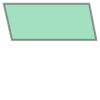

In [18]:
data[0]['geometry']

# Hyp3

In [19]:
TRACKS = ",".join([str(t) for t in TRACK_DICT[AOI_NAME]])
TODAY = datetime.datetime.now().date().strftime('%m%d')
AOI_TOKEN = AOI_NAME.replace(' ', '-')
JOB_NAME = '_'.join([AOI_TOKEN, TRACKS, WEATHER_MODEL, TODAY])
f'JOB_NAME: {JOB_NAME}'

'JOB_NAME: Los-Angeles-0_64_HRRR_0404'

In [20]:
f'JOB_NAME character length: {len(JOB_NAME)}'

'JOB_NAME character length: 26'

In [21]:
assert len(JOB_NAME) <= 30

In [22]:
job_parameters =  [{'granules': ifg_data['reference'],
                    'secondary_granules': ifg_data['secondary'],
                    'weather_model': WEATHER_MODEL,
                    'estimate_ionosphere_delay': True,
                    'compute_solid_earth_tide': True,
                    'frame_id': ifg_data['frame_id'],
                     } for ifg_data in data]
job_parameters[:2]

[{'granules': ['S1A_IW_SLC__1SDV_20220218T015005_20220218T015035_041961_04FF34_65A4'],
  'secondary_granules': ['S1A_IW_SLC__1SDV_20220206T015006_20220206T015035_041786_04F91C_FABC'],
  'weather_model': 'HRRR',
  'estimate_ionosphere_delay': True,
  'compute_solid_earth_tide': True,
  'frame_id': 9847},
 {'granules': ['S1A_IW_SLC__1SDV_20220218T015005_20220218T015035_041961_04FF34_65A4',
   'S1A_IW_SLC__1SDV_20220218T015033_20220218T015101_041961_04FF34_E691'],
  'secondary_granules': ['S1A_IW_SLC__1SDV_20220206T015006_20220206T015035_041786_04F91C_FABC',
   'S1A_IW_SLC__1SDV_20220206T015033_20220206T015101_041786_04F91C_DC3C'],
  'weather_model': 'HRRR',
  'estimate_ionosphere_delay': True,
  'compute_solid_earth_tide': True,
  'frame_id': 9848}]

In [23]:
job_dicts = [{'name': JOB_NAME,
              # NOTE: we are still using the `dev` branch. Change this to "INSAR_ISCE" to use the `main` branch.
              'job_type': 'INSAR_ISCE_TEST',
              'job_parameters': parameters
             }
             for parameters in job_parameters]
job_dicts[:2]

[{'name': 'Los-Angeles-0_64_HRRR_0404',
  'job_type': 'INSAR_ISCE_TEST',
  'job_parameters': {'granules': ['S1A_IW_SLC__1SDV_20220218T015005_20220218T015035_041961_04FF34_65A4'],
   'secondary_granules': ['S1A_IW_SLC__1SDV_20220206T015006_20220206T015035_041786_04F91C_FABC'],
   'weather_model': 'HRRR',
   'estimate_ionosphere_delay': True,
   'compute_solid_earth_tide': True,
   'frame_id': 9847}},
 {'name': 'Los-Angeles-0_64_HRRR_0404',
  'job_type': 'INSAR_ISCE_TEST',
  'job_parameters': {'granules': ['S1A_IW_SLC__1SDV_20220218T015005_20220218T015035_041961_04FF34_65A4',
    'S1A_IW_SLC__1SDV_20220218T015033_20220218T015101_041961_04FF34_E691'],
   'secondary_granules': ['S1A_IW_SLC__1SDV_20220206T015006_20220206T015035_041786_04F91C_FABC',
    'S1A_IW_SLC__1SDV_20220206T015033_20220206T015101_041786_04F91C_DC3C'],
   'weather_model': 'HRRR',
   'estimate_ionosphere_delay': True,
   'compute_solid_earth_tide': True,
   'frame_id': 9848}}]

In [24]:
len(job_dicts)

15

You may want to use `prompt=True` to toggle between Earthdata accounts.

In [25]:
import hyp3_sdk

# uses .netrc; add `prompt=True` to prompt for credentials; 
# hyp3_isce = hyp3_sdk.HyP3('https://hyp3-a19-jpl.asf.alaska.edu')
hyp3_isce = hyp3_sdk.HyP3('https://hyp3-tibet-jpl.asf.alaska.edu')

Uncomment this to submit jobs:

In [26]:
# submitted_jobs = hyp3_isce.submit_prepared_jobs(job_dicts[:])

These are useful snippets to inspect status and view metadata.

In [27]:
jobs = hyp3_isce.find_jobs(name=JOB_NAME)
print(jobs)

0 HyP3 Jobs: 0 succeeded, 0 failed, 0 running, 0 pending.


In [28]:
# jobs[0].to_dict()

In [29]:
# successful_jobs = hyp3_isce.find_jobs(name=JOB_NAME, status_code='SUCCEEDED')
# dicts_success = [j.to_dict() for j in successful_jobs]
# dicts_success[:]

In [30]:
# urls = [d['files'][0]['url'] for d in dicts_success]
# urls

In [31]:
# all_jobs = hyp3_isce.find_jobs(name=JOB_NAME)
# dicts_all = [j.to_dict() for j in all_jobs]
# dicts_all[:]

# Failed Jobs and Resubmission

In [32]:
failed_jobs = hyp3_isce.find_jobs(name=JOB_NAME, status_code='FAILED')
dicts_failed = [j.to_dict() for j in failed_jobs]
dicts_failed[:]

[]

In [33]:
JOB_NAME_RESUBMIT = JOB_NAME + '_v2'

In [34]:
job_dicts_resubmit = [{'name': JOB_NAME_RESUBMIT,
                       # NOTE: we are still using the `dev` branch. Change this to "INSAR_ISCE" to use the `main` branch.
                       'job_type': 'INSAR_ISCE_TEST',
                      'job_parameters': d['job_parameters']
                      }
                     for d in dicts_failed[:1]]
job_dicts_resubmit

[]

In [35]:
# submitted_jobs = hyp3_isce.submit_prepared_jobs(job_dicts_resubmit[:])

In [36]:
jobs_v2 = hyp3_isce.find_jobs(name=JOB_NAME_RESUBMIT)
print(jobs_v2)

0 HyP3 Jobs: 0 succeeded, 0 failed, 0 running, 0 pending.
